# RaspberryPI Kamera Berechnungen
**Autor:** Yasmin Grosenick <br>
**letztes Update:** 17.05.2021 <br>
**letztes Update:** 08.03.2022 by IB<br> 
**Version:** 2.1
<br>
## Inhalt
Mit Hilfe des folgenden Programms können für verschieden Kamera-Chips und Objektive für den Raspberry-Pi mehere Berechnungen durchgeführt werden. <br>
Folgende Eingaben sind dafür notwendig:
- Chip- und Objektiv-Name
- Blendenzahl
- Abstand vom Objektiv zum Objekt bzw. Abstand zum hintersten Punkt des Schärfentiefe-Bereichs  

Folgende Ausgaben erzeugt das Programm (zusätzlich zu den eingegebenen Parametern):
- Vergrößerung
- Gesichtsfeldgröße
- Auflösung
- Schärfentiefe

## Code

In [781]:
# Einbinden notwendiger Bibliotheken 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import math
from tkinter import *
from tkinter import ttk
from tkinter import messagebox
from datetime import datetime
import webbrowser

# Plotte Graphiken direkt hier im Notebook
#%matplotlib inline

# globale Variablen
globalHelpWindowOpen = False
globalInfoWindowOpen = False
globalPlotWindowOpen = False
calculationNumber = 0

Im folgenden Codeblock werden die Standardwerte festgelegt, die zu Programmbeginn ausgewählt sind bzw. angezeigt werden. (default)

In [782]:
# Chip-Bezeichnung
chipname = "HQ"
# Objektiv-Bezeichnung
objektiv = "Telephoto"

### Einlesen der csv-Dateien für Chips und Objektive

In [783]:
cameraChips = pd.read_csv("Chips.csv", sep=";")
cameraChips

Chip  length in mm  width in mm  diagonal in mm  pixel in micrometer
0   V1         3.760        2.740            4.65                 1.40
1   V2         3.680        2.760            4.60                 1.12
2   HQ         6.287        4.712            7.86                 1.55

In [784]:
def setChipData(name):
    """ Funktion, um die Daten des selektierten Chips aus der csv auszulesen und global zu hinterlegen
    
    :param name: Chipname
    :type name: String
    """
    global chipPixel
    global chipDiagonal
    global chipWidth
    global chipLength
    
    chipLength = float(round(cameraChips[cameraChips["Chip"] == name]["length in mm"], 3))
    chipWidth = float(cameraChips[cameraChips["Chip"] == name]["width in mm"])
    chipDiagonal = float(cameraChips[cameraChips["Chip"] == name]["diagonal in mm"])
    chipPixel =float(cameraChips[cameraChips["Chip"] == name]["pixel in micrometer"]) * math.pow(10, -3)
    print("Chip: Länge = " + str(chipLength) + "mm, Breite = " + str(chipWidth)+"mm, Diagonale = " + str(chipDiagonal) + "mm, Pixelgröße = " + str(chipPixel) + "\u03BCm")

In [785]:
cameraObjectives = pd.read_csv("Objektive.csv", sep=";", dtype={"picture": "string"})

cameraObjectives

Objective  focal length in mm  aperture angle hor in deg  \
0          V1                3.60                       53.5   
1          V2                3.04                       62.2   
2   Telephoto               16.00                       21.8   
3  Wide Angle                6.00                       63.0   

   aperture angle ver in deg                   picture  
0                      41.41          Objective_V1.gif  
1                      48.80          Objective_V2.gif  
2                      16.40   Objective_Telephoto.gif  
3                      63.00   Objective_Wideangle.gif

In [786]:
def setObjectiveData(name):
    """ Funktion, um die Daten des selektierten Objektivs aus der csv auszulesen und global zu hinterlegen
    
    :param name: Objektivname
    :type name: String
    """
    global objPictureName
    global objApertureAngleVer
    global objApertureAngleHor
    global objFocalLength
    
    objFocalLength = float(cameraObjectives[cameraObjectives["Objective"] == name]["focal length in mm"])
    objApertureAngleHor = float(cameraObjectives[cameraObjectives["Objective"] == name]["aperture angle hor in deg"])
    objApertureAngleVer = float(cameraObjectives[cameraObjectives["Objective"] == name]["aperture angle ver in deg"])
    picture = str(cameraObjectives[cameraObjectives["Objective"] == name]["picture"])
    l = (re.split('    |\nName',picture))
    objPictureName = l[1].strip()
    print("Objektiv: Brennweite = " + str(objFocalLength) + "mm, horizontaler Öffnungswinkel = " + str(objApertureAngleHor)+"\u00b0, vertikaler Öffnungswinkel = " + str(objApertureAngleVer) + "\u00b0, Dateiname: " + objPictureName)

### Parameter-Berechnungen
Die folgenden Codeblöcke enthalten Funktionen zum Berechnen der einzelnen Parameter.

In [787]:
def getDiagonal(a):
    """ Berechnet die Diagonale eines gleichschenkligen, rechtwinkligen Dreiecks.
    :param a: Seitenlänge der Dreiecksschenkel.
    :type a: float
    
    :return: Hypotenusenlänge, auf 6 NK gerundet
    :rtype: float
    """
    return round(math.sqrt(2*a*a), 6)
    

In [788]:
def calcDOFnear(u, f_s, a, k):
    """ Schärfentiefe (Depth of Field): 
    Berechnet den nähsten Punkt als Abstand von der Hauptebene der Linse zum Objekt, der noch scharf abgebildet werden kann.
    :param u: Unschärfekreis (bspw. Pixeldiagonale)
    :type u: float
    :param f_s: Brennweite des Objektivs
    :type f_s: float
    :param a: Abstand Objekt - Objektiv
    :type a: float
    :param k: Blendenzahl
    :type k: float
    
    :return: Abstand Objektiv - Nahpunkt, auf 3 NK gerundet
    :rtype: float
    """
    DOFnear = (a*f_s**2)/(f_s**2-u*k*(a+f_s))
    return round(DOFnear,1)

def calcDOFfar(u, f_s, a, k):
    """ Schärfentiefe (Depth of Field): Berechnet den Fernpunkt von Linse (Hauptebene) zu Objekt, der noch scharf abgebildet werden kann.
    :param u: Unschärfekreis (bspw. Pixeldiagonale)
    :type u: float
    :param f_s: Brennweite des Objektivs
    :type f_s: float
    :param a: Abstand Objekt - Objektiv
    :type a: float
    :param k: Blendenzahl
    :type k: float
    
    :return: Abstand Objektiv - Fernpunkt, auf 3 NK gerundet
    :rtype: float
    """
    DOFfar = (a*f_s**2)/(f_s**2+u*k*(a+f_s))
    return round(DOFfar,1)


def calcDOF(u, f_s, a, k):
    """ Berechnet den Schärfentiefebereich, in dem noch scharf abgebildet werden kann.
    :param u: Unschärfekreis (bspw. Pixeldiagonale)
    :type u: float
    :param f_s: Brennweite des Objektivs
    :type f_s: float
    :param a: Abstand Objekt - Objektiv
    :type a: float
    :param k: Blendenzahl
    :type k: float
    
    :return: Abstand Nahpunkt - Fernpunkt der Schärfentiefe, auf 3 NK gerundet
    :rtype: float
    """
    DOF = abs(calcDOFfar(u,f_s,a,k)) - abs(calcDOFnear(u,f_s,a,k))
    return round(abs(DOF),1)

def calcFocusDistance(u, f_s, a_h, k):
    """ Berechnet den Abstand vom Objektiv zum Bildpunkt mit dem Fernpunkt der Schärfentiefe.
    
    :param u: Unschärfekreis (bspw. Pixeldiagonale)
    :type u: float
    :param f_s: Brennweite des Objektivs
    :type f_s: float
    :param a_h: Abstand Objekt - Fernpunkt
    :type a_h: float
    :param k: Blendenzahl
    :type k: float
    
    :return: Abstand Objektiv - Fokuspunkt, auf 3 NK gerundet
    :rtype: float
    """
    a = (-a_h*f_s**2 - a_h*u*k*f_s)/(a_h*u*k - f_s**2)
    #a = (a_h*f_s**2 + a_h*u*k*f_s)/(a_h*u*k - f_s**2) # Unter Beachtung der Vorzeichenregel
    return round(a,1)

In [789]:
def angleDegInRad(alpha):
    """ Rechnet einen Winkel von Grad in Rad um.
    
    :param alpha: Winkel in Grad
    :type alpha: float
    
    :return: Winkel in rad
    :rtype: float
    """
    beta = alpha * math.pi /180
    return beta

In [790]:
def calcResolution(k,a,f,chipPixel):
    """ Berechnet das Auflösungsvermögen (minimaler Abstand zwischen zwei unterscheidbaren Punkten in Mikrometer 
        in der Bildebene (auf dem Chip))bei einer mittleren Wellenlänge von 550nm (grün).
    
    :param k: Blendenzahl
    :type k: float
    :param a: Abstand Hauptebene Objektiv - Bildweite
    :type a: float
    :param f: Brennweite des Objektivs
    :type f: float
    :param chipPixel: Pixelgröße Chip
    :type chipPixel: float
    
    :return: Auflösungsvermögen in Mikrometer, auf 2 NK gerundet  
        :res: kleinster beugungsbegrenzter Abstand, der in der Objektebene aufgelöst werden kann.
        :delta_y_min:        -"-                  ,            Chipebene                        .
    :rtype: float
    """
  
    # Berechnung für ferne Objekte
    delta_y_min = 2*1.22 * k * 5.5*10**-1
    
    if (delta_y_min < 4*chipPixel* math.pow(10,3)):
        res = delta_y_min * (abs(a)/f)
    else: 
        res = (delta_y_min/2) * (abs(a)/f)
    
    return (round(res,2), round(delta_y_min,2))

In [791]:
def calcFOV(chipL, objFocalLength, a):
    """ Berechnet die Breite des Gesichtsfeldes anhand der Größe des Kamerachips und des Objektabstandes zur Kamera.
    :param chipL: Länge des Kamerachip in mm
    :type sigma: float
    :param objFocalLength: Abstand hintere Hauptebene des Objektives zum Kamerachip
    :type objFocalLength: float
    :param a: Abstand Objekt - Objektiv
    :type a: float
    
    :return: Breite des Gesichtsfeldes in mm, auf 2 NK gerundet
    :rtype: float
   
    h = 2* math.tan(angleDegInRad(sigma)) * abs(a)
    return round(h, 2)"""
    
    h = (a*chipL)/objFocalLength
    return round(h,2)

In [792]:
def calcMagnification(k,a,f,chipPixel):
    """ Berechnet die förderlich Vergrößerung anhand der Auflösungsvermögen des Auges (in 25cm vom Objekt) und der Kamera 
    (mit Hilfe des Öffnungswinkels). 
    Wie in der Dokumentation beschrieben wären in 25cm Abstand zwei Punkte auf dem Insekt in einem Abstand von 0,146mm noch auflösbar. 
    (Augapfellänge 24mm, Pixelgröße im Auge 7 Mikrometer => es sind 2*7ym *250mm / 24mm in der Objektebene auflösbar.)
    
    :param k: Blendenzahl
    :type k: float
    :param a: Abstand Hauptebene Objektiv - Bildweite
    :type a: float
    :param f: Brennweite des Objektivs
    :type f: float
    :param chipPixel: Pixelgröße Chip
    :type chipPixel: float
    
    :return: förderliche Vergrößerung, auf 2 NK gerundet
    :rtype: float
    """
    dx_min, dy_min = calcResolution(k,a,f,chipPixel)
    beta = 146.0 / dx_min
    return round(beta,2)

### Oberfläche

Hier werden Funktionen für die Oberfläche und deren Elemente definiert. <br>
Zunächst der Button um Berechnungen auszuführen:

In [793]:
def calcButtonClicked(abstand, blendenzahl, hintereSchaerfentiefe, chipAbstand):
    """ Funktion, die nach Klick auf den "Berechnungen ausführen"-Button alle Berechnungsfunktionen aufruft und 
    die entsprechenden Oberflächenelemente für die Ausgabe erzeugt
    
    :param abstand: Abstand Objekt - Objektiv (aus dem Eingabefeld in der UI)
    :type abstand: float
    :param blendenzahl: Blendenzahl (aus dem Eingabefeld in der UI)
    :type blendenzahl: float
    :param hintereSchaerfentiefe: Abstand Fernpunkt Schärfentiefe - Objektiv (aus dem Eingabefeld in der UI)
    :type hintereSchaerfentiefe: float
    :param chipAbstand: Abstand Objektiv - Chip (aus dem Eingabefeld in der UI)
    :type chipAbstand: float
    
    """
    # global calc 
    global canv
    global calculationNumber
    global mainFrame2
    global scrollableFrame
    global canvas
    global scrollbar
    
    # Chip- und Objektiv-Daten
    global chipPixel 
    global chipDiagonal
    global chipWidth 
    global chipLength
    global objPictureName
    global objApertureAngleVer
    global objApertureAngleHor
    global objFocalLength
    
    global calcNumberList
    global chipnameList
    global objektivList
    global objektAbstandList
    global chipAbstandList
    global blendenzahlList
    global vergrList
    global gesichtsfeldList
    global auflList
    global schaerfentiefeList
    
    # Abschneiden möglicher Leerzeichen
    abstand = abstand.get().strip()         
    blendenzahl = blendenzahl.get().strip()
    hintereSchaerfentiefe = hintereSchaerfentiefe.get().strip() 
    chipAbstand = chipAbstand.get().strip()
    
    # Wenn Pflichtfelder nicht gefüllt sind, wird Berechnung abgebrochen.
    if (blendenzahl == "" or (abstand == "" and hintereSchaerfentiefe == "") or chipAbstand ==""):
        messagebox.showerror("Parameter", "Berechnungen können nicht durchgeführt werden, es fehlt mind. ein Parameter.")
        return
    
    # Nummer der aktuellen Berechnung
    calculationNumber += 1
    
    # Felder sperren
    comboboxChips.configure(state='disabled')
    comboboxObjektives.configure(state='disabled')
    entryAbstand.configure(state='disabled')
    entryBlendenzahl.configure(state='disabled')
    entryHintereSchaerfentiefe.configure(state='disabled')
    entryChipAbstand.configure(state='disabled')
    calcButton.configure(state='disabled')
    editButton.configure(state='normal')
    
    # Zuweisung der notwendigen Parameter
    pixelDiagonal = getDiagonal(chipPixel)  # Annahme: u' = PixelDiagonale
    
    k = float(blendenzahl.replace(",", "."))
 #new   
    if not (chipAbstand==""):
        f_s = float(chipAbstand.replace(",","."))
    else:
        f_s = float(objFocalLength.replace(",","."))
    #f_s = objFocalLength
    a_c = float(chipAbstand.replace(",", "."))
    if not (abstand == ""):
        a = -1 * float(abstand.replace(",", "."))
    if not (hintereSchaerfentiefe == ""):
        a_H = -1 * float(hintereSchaerfentiefe.replace(",", "."))
        a = calcFocusDistance(2*pixelDiagonal, f_s, a_H, k)
    else:
        a_H = 0
    
    print("a= "+str(a)+ ", a_H = " + str(a_H) + ", k= " + str(k)+ ", Brennweite: " + str(f_s))
    
    # Auswertungsabschnitt initialisieren
    if (calculationNumber==1):
        Label(scrollableFrame, font = ("Calibri", 12, "bold"), text = "Nr.", bg="#3F71FE", fg = "white").grid(row = 0, column = 0, ipadx = 1, ipady = 1, sticky = 'wens')
        Label(scrollableFrame, font = ("Calibri", 12, "bold"), text= "Chip", bg="#3F71FE", fg = "white").grid(row = 0, column = 1, ipadx = 1, ipady = 1, sticky = 'wens')
        Label(scrollableFrame, font = ("Calibri", 12, "bold"), text= "Objektiv", bg="#3F71FE", fg = "white").grid(row = 0, column = 2, ipadx = 1, ipady = 1, sticky = 'wens')
        Label(scrollableFrame, font = ("Calibri", 12, "bold"), text= "Objekt-Abstand (in mm)", bg="#3F71FE", fg = "white").grid(row = 0, column = 3, ipadx = 1, ipady = 1, sticky = 'wens')
        Label(scrollableFrame, font = ("Calibri", 12, "bold"), text= "Chip-Abstand (in mm)", bg="#3F71FE", fg = "white").grid(row = 0, column = 4, ipadx = 1, ipady = 1, sticky = 'wens')
        Label(scrollableFrame, font = ("Calibri", 12, "bold"), text= "Blendenzahl", bg="#3F71FE", fg = "white").grid(row = 0, column = 5, ipadx = 1, ipady = 1, sticky = 'wens')
        Label(scrollableFrame, font = ("Calibri", 12, "bold"), text= "fVergrößerung", bg="#3F71FE", fg = "white").grid(row = 0, column = 6, ipadx = 1, ipady = 1, sticky = 'wens')
        Label(scrollableFrame, font = ("Calibri", 12, "bold"), text= "Gesichtsfeld (in mm)", bg="#3F71FE", fg = "white").grid(row = 0, column = 7, ipadx = 1, ipady = 1, sticky = 'wens')
        Label(scrollableFrame, font = ("Calibri", 12, "bold"), text= "Auflösungsvermögen (in \u03BCm)", bg="#3F71FE", fg = "white").grid(row = 0, column = 8, ipadx = 1, ipady = 1, sticky = 'wens')
        Label(scrollableFrame, font = ("Calibri", 12, "bold"), text= "Schärfentiefe Bereich (in mm)", bg="#3F71FE", fg = "white").grid(row = 0, column = 9, ipadx = 1, ipady = 1, sticky = 'wens')

        mainFrame2.grid(row = 1, column = 0)       
        canvas.pack(side="left", fill=BOTH, expand=True)
        scrollbar.pack(side="right", fill="y")
    
    # entsprechende Berechnungen aufrufen (sofern mehr berechnet werden soll, müsste die 10 verändert werden)
    for i in range(10):
        label = Label(scrollableFrame, bg="#3F71FE", fg = "white")
        label.grid(row=calculationNumber, column=i, ipadx = 1, ipady = 1, sticky = 'wens')
        
        if(i==0):
            label.configure(text = str(calculationNumber))
            calcNumberList.append(calculationNumber)
        elif (i == 1):
            # Chipname
            label.configure(text = chipname)
            chipnameList.append(chipname)
        elif (i == 2):
            # Objektivname
            label.configure(text = objektiv)
            objektivList.append(objektiv)
        elif (i == 3):
            # Abstand zum Objekt
            label.configure(text = str(a))
            objektAbstandList.append(a)
        elif (i == 4):
            # Abstand zum Chip
            label.configure(text = str(a_c))
            chipAbstandList.append(a_c)
        elif (i == 5):
            # Blendenzahl
            label.configure(text = str(k))
            blendenzahlList.append(k)
        elif (i == 6):
            # förderliche Vergrößerung
            magnification = calcMagnification(k,a,f_s,chipPixel)
            label.configure(text = str(magnification))
            vergrList.append(magnification)
        elif (i == 7):
            # Gesichtsfeld
            FOV1 = calcFOV(chipLength, objFocalLength, -a)
            FOV2 = calcFOV(chipWidth, objFocalLength, -a)
            textFOV = str(FOV1)+ " x " + str(FOV2)
            label.configure(text = textFOV)
            gesichtsfeldList.append(textFOV)
        elif (i == 8):
            # Auflösung
            resolution1, resolution2 = calcResolution(k,a,f_s,chipPixel)
            #resolution2 = calcResolution(k,a,f_s,chipPixel)
            textRes = str(resolution1) + " und " + str(resolution2)
            label.configure(text = textRes)
            auflList.append(textRes)
        else:
            # Schärfentiefebereich
            circ_confusion = max(resolution2*math.pow(10,-3),2*pixelDiagonal)
            if not (abstand == ""):
                DOFfar = calcDOFfar(circ_confusion, f_s, a, k)
                DOFnear = calcDOFnear(circ_confusion, f_s, a, k)
                DOF = calcDOF(circ_confusion, f_s, a, k)
                
            if not (hintereSchaerfentiefe == ""):
                DOFfar = a_H
                DOFnear = calcDOFnear(circ_confusion, f_s, a, k)
                print(DOFnear,'  ',circ_confusion,'  ',f_s,'  ',a,'  ',k)
                DOF = calcDOF(circ_confusion, f_s, a, k)
            
            textDOF = str(DOFfar)+" bis " + str(DOFnear) + " = " + str(DOF) 
            label.configure(text = textDOF)
            schaerfentiefeList.append(textDOF)

Aktion beim Klick des Editieren-Button:

In [794]:
def editButtonClicked():
    """ Funktion, die die Eingabe-Felder reaktiviert, wenn der Editieren-Button geklickt wurde (nachdem die Felder beim Berechnungen ausführen gesperrt werden)
    """
    comboboxChips.configure(state='enabled')
    comboboxObjektives.configure(state='enabled')
    entryAbstand.configure(state='normal')
    entryBlendenzahl.configure(state='normal')
    entryHintereSchaerfentiefe.configure(state='normal')
    entryChipAbstand.configure(state='normal')
    calcButton.configure(state='normal')
    editButton.configure(state='disabled')

Aktion bei Selektion eines Kamera-Chip:

In [795]:
def comboChipSelected(event):
    """ Funktion, die auf eine Änderung des gewählten Combobox-Eintrags reagiert und global den aktuellen Chip-Namen aktualisiert
    
    :param event: Ereignis, das standardmäßig bei Comboboxen übergeben wird
    """
    global chipname
    currentChip = comboboxChips.get();
    chipname = currentChip
    print("Aktueller Chip: " + chipname)

Aktion bei Selektion eines Kamera-Objektivs:

In [796]:
def comboObjectiveSelected(event):
    """ Funktion, die auf eine Änderung des gewählten Combobox-Eintrags reagiert und global den aktuellen Objektiv-Namen aktualisiert
    
    :param event: Ereignis, das standardmäßig bei Comboboxen übergeben wird
    """
    global objektiv
    global objPictureName
    
    currentObjective = comboboxObjektives.get()
    objektiv = currentObjective
    oData = setObjectiveData(objektiv)
    oPictureName = objPictureName
    print(oPictureName)
    
    picture = PhotoImage(file="Pictures\u005C".strip() + oPictureName)
    objectivePictureLabel.configure(image = picture)
    objectivePictureLabel.image = picture
    #print("Aktuelles Objektiv: " + objektiv)

Aktion beim Schließen eines Fensters (Haupt-, Hilfe-, Info- und Plot-Fenster)

In [797]:
def closeMainWindow():
    """ Funktion, die auf das Schließen des Hauptfenster reagiert. Es wird die Nachfrage gestellt, ob das Fenster geschlossen werden soll. Falls das Häkchen geseetzt wurde, werden die Berechnungen in einer csv-Datei abgelegt.
    """
    global calcNumberList
    global chipnameList
    global objektivList
    global objektAbstandList
    global chipAbstandList
    global blendenzahlList
    global vergrList
    global gesichtsfeldList
    global auflList
    global schaerfentiefeList
    global saveCalculations
    
    if messagebox.askokcancel("Schließen", "Wollen Sie das Programm beenden?"):
        # Wenn Häkchen gesetzt ist, aktuelle Berechnungen speichern
        if (saveCalculations.get() == 1):
            print("Häkchen gesetzt")
            #print("Nummern: " + str(calcNumberList)
            #print("Chip: " + str(chipnameList)
            csvData = {'Nr.': calcNumberList, 'Chip': chipnameList, 'Objektiv': objektivList, 'Abstand zum Objekt': objektAbstandList, 
                       'Abstand zum Chip' : chipAbstandList, 'Blendenzahl' : blendenzahlList, 'förderliche Vergrößerung' : vergrList, 
                       'Gesichtsfeld' : gesichtsfeldList, 'Auflösung' : auflList, 'Schärfentiefebereich' : schaerfentiefeList}
            df = pd.DataFrame(csvData)
            csvName = "Raspi_Kamera_Berechnungen_" + datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + ".csv"
            df.to_csv(csvName)
    
        hauptfenster.destroy()
        
def closeHelpWindow():
    """ Funktion, die das Hilfe-Fensters schließt
    """
    global helpWindow
    global globalHelpWindowOpen
    globalHelpWindowOpen = False
    helpWindow.destroy()
    helpWindow.update()
    
def closeInfoWindow():
    """ Funktion, die das Info-Fensters schließt
    """
    global infoWindow
    global globalInfoWindowOpen
    globalInfoWindowOpen = False
    infoWindow.destroy()
    infoWindow.update()
    
def closePlotWindow():
    """ Funktion, die das Plot-Fensters schließt
    """
    global plotWindow
    global globalPlotWindowOpen
    globalPlotWindowOpen = False
    plotWindow.destroy()
    plotWindow.update()

Aktion beim Klick des Hilfe-Button:

In [798]:
def helpButtonClicked():
    """ Funktion, die auf den Klick des Hilfe-Button ("?") reagiert. Es wird ein neues Fenster geöffnet, in dem die Programmhinweise angezeigt werden.
    """
    global globalHelpWindowOpen
    global helpWindow
    if globalHelpWindowOpen == False:
        # glabale Variable auf True setzen, damit kein zweites (gleiches) Fenster erzeugt werden kann
        globalHelpWindowOpen = True 
        helpWindow = Toplevel(hauptfenster)
        helpWindow.title(" Hilfe")
        helpFrame1 = Frame(helpWindow, width = 600, height = 200)
        Label(helpFrame1, text = "HowTo", font=("Calibri", 18)).pack()
        helpFrame1.pack()
        
        helpFrame2 = Frame(helpWindow, width = 600, height = 200)
        Label(helpFrame2, text = "Kopfzeile").grid(row = 0, column = 0, sticky = W, pady = 3, padx = 2)
        Label(helpFrame2, text = "Über den Button \"i\" kann das Impressum inklusive der verwendeten Quellen aufgerufen werden.").grid(row = 0, column = 1, sticky = W)
        
        Label(helpFrame2, bg="#81A1FD", text = "Skizzen").grid(row = 1, column = 0, sticky = W, pady = 3, padx = 2)
        Label(helpFrame2, text = "In den Skizzen sind alle Parameter, die vom Nutzer eingegeben werden können, soweit möglich eingezeichnet.").grid(row = 1, column = 1, sticky = W)
        
        Label(helpFrame2, text = "Parameter").grid(row = 2, column = 0, sticky = W, pady = 3, padx = 2)
        Label(helpFrame2, text = "Im Dropdown-Menü \"Chip\" kann der verwendete RaspberryPi Kamera Chip ausgewählt werden. Für jeden Chip sind die Abmessungen (Länge, Breite, Diagonale) sowie die Pixelgröße hinterlegt.").grid(row = 2, column = 1, sticky = W)
        Label(helpFrame2, text = "Im Dropdown-Menü \"Objektiv\" kann der verwendete RaspberryPi Kamera Objektiv ausgewählt werden. Für jedes Objektiv sind Brennweite sowie die Öffnungswinkel (horizontal, vertikal) hinterlegt.").grid(row = 3, column = 1, sticky = W)
        Label(helpFrame2, text = "In den entsprechenden csv-Dateien können weitere Chips und Objektive manuell hinzugefügt werden, indem eine neue Zeile mit den entsprechenden Daten hinzugefügt wird.").grid(row = 4, column = 1, sticky = W)
        Label(helpFrame2, text = "Abstände werden in mm gemessen und müssen grundsätzlich nicht vorzeichenbehaftet eingegeben werden, Ausgaben erfolgen allerdings mit korrekten Vorzeichen.").grid(row = 5, column = 1, sticky = W)
        Label(helpFrame2, text = "Wenn das Häkchen \"Berechnungen beim Beenden als csv speichern\" gesetzt wird, werden die ab diesem Zeitpunkt berechneten Parameter in einer mit Zeitangabe versehenen csv-Datei abgelegt.").grid(row = 6, column = 1, sticky = W)
        Label(helpFrame2, text = "Im unteren Bereich können ein Maximalabstand zum Objektiv sowie eine Schrittweite angegeben werden. Mit Hilfe dieser Parameter können Diagramme zu Schärfentiefe, Auflösungsvermögen und Gesichtsfeld erzeugt werden.").grid(row = 7, column = 1, sticky = W)
        Label(helpFrame2, text = "Die Diagramme werden genauer, je kleiner die Schrittweite für den Abstand angegeben wird. Für die Schärfentiefe werden Graphen mit voreingestellten Blendenzahlen erzeugt.").grid(row = 8, column = 1, sticky = W)
        Label(helpFrame2, text = "Grundsätzlich ist zu beachten, dass bspw. durch Herausdrehen des Teleobjektivs eine kürzere Distanz zum Objekt erreicht werden kann, sodass dieses dennoch weiterhin scharf abgebildet wird.").grid(row = 9, column = 1, sticky = W)
        
        Label(helpFrame2, bg="#3F71FE", text = "Ausgabe").grid(row = 20, column = 0, sticky = W, pady = 3, padx = 2)
        Label(helpFrame2, text = "Es werden grundsätzlich alle berechneten und manuell eingegebenen Parameter in der Tabelle angezeigt.").grid(row = 20, column = 1, sticky = W)
        helpFrame2.pack()
        
        helpWindow.protocol("WM_DELETE_WINDOW", closeHelpWindow)

Aktion beim Klick des Plot-Buttons

In [799]:
def plotButtonClicked(maxAbstand, schrittweite):
    """ Funktion, die auf den Klick des "Berechnungen plotten"-Button reagiert. Es wird ein neues Fenster geöffnet, in dem für den eingegebenen Maximalabstand mit Hilfe der Schrittweite erzeugten Plots angezeigt werden.
    """
    global globalPlotWindowOpen
    global plotWindow
    if globalPlotWindowOpen == True:
        return
    
    maxAbstand = maxAbstand.get().strip()
    schrittweite = schrittweite.get().strip()
    
    # Wenn Pflichtfelder nicht gefüllt sind, wird Berechnung abgebrochen.
    if (maxAbstand == "" or schrittweite ==""):
        messagebox.showerror("Parameterplot", "Plot der Parameter kann nicht durchgeführt werden, es fehlt mind. ein Parameter.")
        return
    
    # glabale Variable auf True setzen, damit kein zweites (gleiches) Fenster erzeugt werden kann
    globalPlotWindowOpen = True 
    plotWindow = Toplevel(hauptfenster)
    plotWindow.title(" Parameter-Plot")
    plotFrame1 = Frame(plotWindow, width = 600, height = 200)
    Label(plotFrame1, text = "Plots der Parameter", font=("Calibri", 18)).pack()
    plotFrame1.pack()
        
    plotFrame2 = Frame(plotWindow, width = 600, height = 200)
    plotFrameDOF = Frame(plotFrame2)
    plotFrameDOF.grid(row = 0, column = 0)
    
    plotFrameFOV = Frame(plotFrame2)
    plotFrameFOV.grid(row = 0, column = 1)
    
    plotFrameRes = Frame(plotFrame2)
    plotFrameRes.grid(row = 0, column = 2)
    
    plotFrame2.pack()
    plotWindow.protocol("WM_DELETE_WINDOW", closePlotWindow)

    
    maxAbstand = float(maxAbstand)
    schrittweite = float(schrittweite)
    # Ganzzahldivision
    schritte = int(maxAbstand//schrittweite)
    
    abstand = 0
    blende = 0
    
    # Listen für die Abstände und Daten je Blendenzahl
    abstaende = []
    dofList1_4 = []
    dofList2_8 = []
    dofList5_6 = []
    dofList8 = []
    dofList16 = []
    
    fovVerList = []
    fovHorList = []
    
    resVerList = []
    resHorList = []
    
    for i in range(schritte):
        abstand = abstand - schrittweite
        abstaende.append(abstand)
        
        resolution1, resolution2 = calcResolution(1.4,abstand,objFocalLength,chipPixel)
        circ_confusion = max(resolution2*math.pow(10,-3),2*getDiagonal(chipPixel))
        DOF1_4 = calcDOF(circ_confusion, objFocalLength, abstand, 1.4)
        dofList1_4.append(DOF1_4)
        
        resolution1, resolution2 = calcResolution(2.8,abstand,objFocalLength,chipPixel)
        circ_confusion = max(resolution2*math.pow(10,-3),2*getDiagonal(chipPixel))
        DOF2_8 = calcDOF(circ_confusion, objFocalLength, abstand, 2.8)
        dofList2_8.append(DOF2_8)
        
        resolution1, resolution2 = calcResolution(5.6,abstand,objFocalLength,chipPixel)
        circ_confusion = max(resolution2*math.pow(10,-3),2*getDiagonal(chipPixel))
        DOF5_6 = calcDOF(circ_confusion, objFocalLength, abstand, 5.6)
        dofList5_6.append(DOF5_6)
        
        resolution1, resolution2 = calcResolution(8,abstand,objFocalLength,chipPixel)
        circ_confusion = max(resolution2*math.pow(10,-3),2*getDiagonal(chipPixel))
        DOF8 = calcDOF(circ_confusion, objFocalLength, abstand, 8)
        dofList8.append(DOF8)
        
        resolution1, resolution2 = calcResolution(16,abstand,objFocalLength,chipPixel)
        circ_confusion = max(resolution2*math.pow(10,-3),2*getDiagonal(chipPixel))
        DOF16 = calcDOF(circ_confusion, objFocalLength, abstand, 16)
        dofList16.append(DOF16)
        
        FOV1 = calcFOV(chipLength, objFocalLength, -abstand)
        fovVerList.append(FOV1)
        
        FOV2 = calcFOV(chipWidth, objFocalLength, -abstand)
        fovHorList.append(FOV2)
        
    for i in [1.4, 2.8, 5.6, 8, 11, 16]:    
        res1, res2 = calcResolution(i,abstand,objFocalLength,chipPixel)
        resVerList.append(res1)
        resHorList.append(res2)
    
    print(dofList1_4)
    
    fig1, ax1 = plt.subplots()
    ax1.plot(abstaende, dofList1_4, label="k = 1,4")
    ax1.plot(abstaende, dofList2_8, label="k = 2,8")
    ax1.plot(abstaende, dofList5_6, label="k = 5,6")
    ax1.plot(abstaende, dofList8, label="k = 8")
    ax1.plot(abstaende, dofList16, label="k = 16")
    fig1.legend(loc = "upper right") # "best" würde theoretisch die beste Stelle finden, bringt aber Exception
    ax1.set_xlabel("Abstand a in mm")
    ax1.set_ylabel("Schärfentiefe \u0394a in mm")
    fig1.suptitle("Schärfentiefe")
    
    # Platzieren Schärfentiefe Plot
    plotDOF = FigureCanvasTkAgg(fig1, plotFrameDOF)
    plotDOF.get_tk_widget().pack()
    
    fig2, ax2 = plt.subplots()
    ax2.plot(abstaende, fovVerList, label = "vertikal")
    ax2.plot(abstaende, fovHorList, label = "horizontal")
    fig2.legend(loc = "upper right")
    ax2.set_xlabel("Abstand a in mm")
    ax2.set_ylabel("Gesichtsfeldausdehnung in mm")
    fig2.suptitle("Gesichtsfeld")
    
    # Platzieren Gesichtsfeld Plot
    plotFOV = FigureCanvasTkAgg(fig2, plotFrameFOV)
    plotFOV.get_tk_widget().pack()
    
    fig3, ax3 = plt.subplots()
    ax3.plot([1.4, 2.8, 5.6, 8, 11, 16], resVerList, label = "objektseitig")
    ax3.plot([1.4, 2.8, 5.6, 8, 11, 16], resHorList, label = "chipseitig")
    fig3.legend(loc = "upper right")
    ax3.set_xlabel("k")
    ax3.set_ylabel("Auflösung in \u03BCm")
    fig3.suptitle("1/Auflösung (beugungs- & pixelbegrenzt)")
    
    # Platzieren Gesichtsfeld Plot
    plotRes = FigureCanvasTkAgg(fig3, plotFrameRes)
    plotRes.get_tk_widget().pack()

In [800]:
def callback(url):
    """ Funktion zum Öffnen eines Links im Webbrowser
    
    :param url: Link zur gewünschten Website
    :type url: String
    """
    webbrowser.open_new(url)

Aktion beim Klick des Info-Button:

In [801]:
def infoButtonClicked():
    """ Funktion, die auf den Klick des Info-Button ("i") reagiert. Es wird ein neues Fenster geöffnet, in dem das Impressum sowie verwendete Quellen angezeigt werden.
    """
    global globalInfoWindowOpen
    global infoWindow
    global logoBMU
    global logoBeuth
    
    if globalInfoWindowOpen == False:
        # glabale Variable auf True setzen, damit kein zweites (gleiches) Fenster erzeugt werden kann
        globalInfoWindowOpen = True
        infoWindow = Toplevel(hauptfenster)
        infoWindow.title(" Impressum")
        
        infoFrame1 = Frame(infoWindow, width = 600, height = 200)
        Label(infoFrame1, text = "Impressum", font=("Calibri", 18)).pack()
        infoFrame1.pack()
        
        infoFrame2 = Frame(infoWindow, width = 600, height = 200)
        Label(infoFrame2, text = "Autorin: ", font = ("Calibri", 11, "bold")).grid(row = 0, column = 0)
        Label(infoFrame2, text = "Yasmin Grosenick").grid(row = 0, column = 1)
        Label(infoFrame2, text = "letzte Aktualisierung: ", font = ("Calibri", 11, "bold")).grid (row = 0, column = 2)
        Label(infoFrame2, text = datetime.now().strftime('%d.%m.%Y')).grid (row = 0, column = 3)
        infoFrame2.pack()
        
        infoFrame2a = Frame(infoWindow, width = 600, height = 200)
        Label(infoFrame2a, text = "Bei Fragen wenden Sie sich bitte an Prof. Ingeborg Beckers: beckers@beuth-hochschule.de", font = ("Calibri", 11)).grid (row = 0, column = 0)
        infoFrame2a.pack()
        
        infoFrame3a = Frame(infoWindow, width = 600, height = 200)
        Label(infoFrame3a, text = "Ein Projekt im Rahmen der BMU-Förderlinie", font = ("Calibri", 11)).grid(row = 0, column = 0, ipadx =4)
        linkBMU = Label(infoFrame3a, text="KI-Leuchttürme", font = ("Calibri", 11) ,fg="blue", cursor="hand2")
        linkBMU.grid(row=0, column = 1)
        linkBMU.bind("<Button-1>", lambda e: callback("https://www.bmu.de/themen/europa-internationales-nachhaltigkeit-digitalisierung/digitalisierung-und-umwelt/unsere-foerderinitiative-ki-leuchttuerme/"))
        Label(infoFrame3a, text = "an der Beuth-Hochschule für Technik Berlin.", font = ("Calibri", 11)).grid(row = 0, column = 2, ipadx =4)
       
        infoFrame3a.pack()
        
        infoFrame3b = Frame(infoWindow, width = 600, height = 200)
        Label(infoFrame3b, text="", image = logoBMU).grid(row = 0, column = 0)
        Label(infoFrame3b, text = "", image = logoBeuth).grid(row = 0, column = 1)
        infoFrame3b.pack()
        
        infoframe4a = Frame(infoWindow, width = 600, height = 200)
        
        Label(infoframe4a, text = "verwendete Quellen", font = ("Calibri", 14)).pack()
        infoframe4a.pack()
        
        infoframe4b = Frame(infoWindow, width = 600, height = 200)
        link1 = Label(infoframe4b, text = "Raspberry Pi Module", font = ("Calibri", 11) ,fg="blue", cursor="hand2")
        link1.grid(row = 1, column = 0)
        link1.bind("<Button-1>", lambda e: callback("https://www.raspberrypi.org/documentation/hardware/camera/"))
        
        
        link2 = Label(infoframe4b, text = "Weitwinkelobjektiv", font = ("Calibri", 11) ,fg="blue", cursor="hand2")
        link2.grid(row = 1, column = 1)
        link2.bind("<Button-1>", lambda e: callback("https://www.adafruit.com/product/4562"))
        
        
        link3 = Label(infoframe4b, text = "Teleobjektiv", font = ("Calibri", 11) ,fg="blue", cursor="hand2")
        link3.grid(row = 1, column = 2)
        link3.bind("<Button-1>", lambda e: callback("https://cdn-shop.adafruit.com/product-files/4562/4562_datasheet.pdf"))
        
        infoframe4b.pack()
        
        infoWindow.update()
        
        infoWindow.protocol("WM_DELETE_WINDOW", closeInfoWindow)

Im Folgenden wird die Oberfläche aufgebaut. Dafür werden zunächst die beiden Combo-Boxen mit Chip- und Objektivnamen dynamisch aus den entsprechenden csv-Dateien gefüllt. <br>
Außerdem werden die Daten von Objektiv und Chip einmal initial abgelegt und Listen für die berechneten Parameter erzeugt, die später gefüllt werden.

In [802]:
cList = []
for i in range(len(cameraChips["Chip"])):
    cList.append(cameraChips["Chip"][i])

oList = []
for i in range(len(cameraObjectives["Objective"])):
    oList.append(cameraObjectives["Objective"][i])

# Setzen der Objektiv- und Chipdaten
setObjectiveData(objektiv)
setChipData(chipname)


calcNumberList = []
chipnameList = []
objektivList = []
objektAbstandList = []
chipAbstandList = []
blendenzahlList = []
vergrList = []
gesichtsfeldList = []
auflList = []
schaerfentiefeList = []

Objektiv: Brennweite = 16.0mm, horizontaler Öffnungswinkel = 21.8°, vertikaler Öffnungswinkel = 16.4°, Dateiname: Objective_Telephoto.gif
Chip: Länge = 6.287mm, Breite = 4.712mm, Diagonale = 7.86mm, Pixelgröße = 0.0015500000000000002μm


Die verschiedenen Programmabschnitte sind in Frames positioniert. <br>
- Im Header sind neben der Überschrift die Button für das Impressum und die Hilfe.
- Darauf folgt eine Aufbauskizze.
- Im dritten Bereich sind Eingabemöglichkeiten für die Parameter.
- Der letzte Bereich wird bei der ersten Berechnung initialisiert und enthält die berechneten Größen.  

[0.0, 0.2, 0.4, 0.6, 1.0, 1.4, 2.0, 2.6, 3.3, 4.1]
a= -115.0, a_H = 0, k= 5.6, Brennweite: 16.0
a= -115.9, a_H = -117.0, k= 5.6, Brennweite: 16.0
-114.0    0.00752    16.0    -115.9    5.6


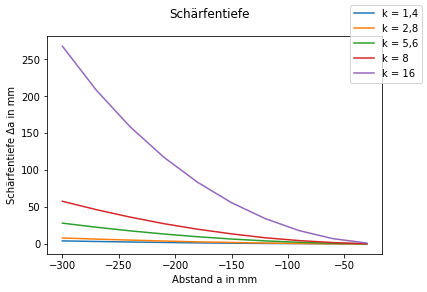

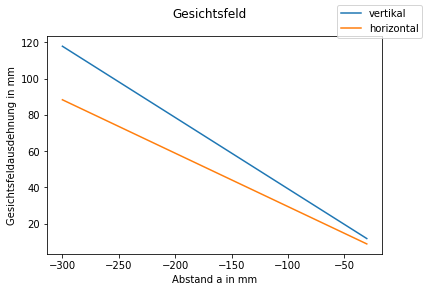

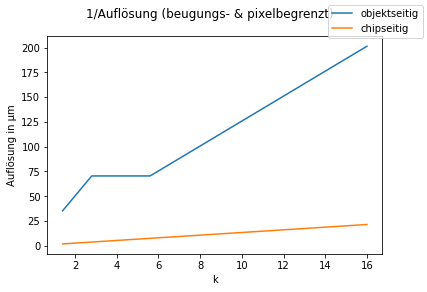

In [803]:
hauptfenster = Tk()

logoBMU = PhotoImage(file="Pictures\Logo_BMU.gif")
logoBeuth = PhotoImage(file = "Pictures\Logo_Beuth.gif")

mainFrame1 = Frame(hauptfenster, width = 801, height = 201)


# Frame für Titel und Hilfebutton
globalHelpWindowOpen = False
frame1 = Frame(mainFrame1, width = 800, height = 200)
Label(frame1, text = "RaspberryPi Kamera Berechnungen", font=('Calibri', 20)).grid(row=0, column =1, ipadx = 10)
helpButton = Button(frame1, text = "?", command = lambda: helpButtonClicked())
helpButton.grid(row=0, column= 2)
infoButton = Button(frame1, text = "i", command = lambda: infoButtonClicked())
infoButton.grid(row=0, column=0)
frame1.pack()

# Frame für Bilder
frame2 = Frame(mainFrame1, width = 800, height = 200, bg="#81A1FD") 
skizze1 = PhotoImage(file="Pictures\Skizze1_Aufbau.gif")
Label(frame2, text="", image = skizze1).grid(row = 0, column = 0, padx = 35)
skizze2 = PhotoImage(file="Pictures\Skizze2_Schärfentiefe2.gif")
Label(frame2, text="", image = skizze2).grid(row = 0, column = 1, pady = 10, padx = 10)
frame2.pack(fill=X)

# Frame für Objektivbild
helpFrame = Frame(mainFrame1, width = 200, height = 200)
helpFrame.pack()
frame3 = Frame(helpFrame, width = 200, height = 300)
pictureObjectiveV1 = PhotoImage(file="Pictures\Objective_Telephoto.gif")
objectivePictureLabel = Label(frame3, text ="", image = pictureObjectiveV1)
objectivePictureLabel.grid(row = 0, column = 0, padx = 5, pady = 3)
frame3.grid(row = 0, column = 0)

# Frame für Eingaben
frame4 = Frame(helpFrame, width = 800, height = 200)
Label(frame4, text = "Chip").grid(row = 0, column = 0, padx = 10, pady = 5, sticky = "w")
Label(frame4, text = "Objektiv").grid(row = 0, column = 2, padx = 10, sticky = "w")

comboboxChips = ttk.Combobox(frame4, values=cList)
comboboxChips.current(2)
comboboxChips.grid(row = 0, column=1)
comboboxChips.bind("<<ComboboxSelected>>", comboChipSelected)

comboboxObjektives = ttk.Combobox(frame4, values=oList)
comboboxObjektives.current(2)
comboboxObjektives.grid(row = 0, column = 3)
comboboxObjektives.bind("<<ComboboxSelected>>", comboObjectiveSelected)

Label(frame4, text = "Abstand Objekt - Linse a (mm): ").grid(row = 1, column = 0, padx = 10, sticky = "w")
Label(frame4, text = "Blendenzahl: ").grid(row = 1, column = 2, padx = 10, sticky = "w")
entryAbstand = Entry(frame4)
entryAbstand.grid(row=1, column=1)
entryBlendenzahl = Entry(frame4)
entryBlendenzahl.grid(row=1, column=3)

Label(frame4, text = "hinterster scharfer Punkt a_H: ").grid(row = 2, column = 0, padx = 10, sticky = "w")

entryHintereSchaerfentiefe = Entry(frame4)
entryHintereSchaerfentiefe.grid(row=2, column=1)

Label(frame4, text = "Abstand Chip - Objektiv a' (mm): ").grid(row = 2, column = 2, padx = 10, sticky = "w")
entryChipAbstand = Entry(frame4)
entryChipAbstand.grid(row=2, column=3)
entryChipAbstand.insert(0, "16")

editButton = Button(frame4, text = "editieren", state = "disabled", command = lambda: editButtonClicked())
editButton.grid(row = 0, column = 4)

calcButton = Button(frame4, text = "Berechnungen ausführen", command = lambda: calcButtonClicked(entryAbstand, entryBlendenzahl, entryHintereSchaerfentiefe, entryChipAbstand))
calcButton.grid(row = 2, column = 4, padx = 5)
frame4.grid(row = 0, column = 1)

saveCalculations = IntVar()
Checkbutton(frame4, text="Berechnungen beim Beenden als csv speichern", variable=saveCalculations).grid(row=1, column = 4, padx = 5, sticky=W)


Label(frame4, text = "Maximaler Abstand (mm): ").grid(row = 3, column = 0, padx = 10, pady = 30, sticky = "w")
entryMaxAbstand = Entry(frame4)
entryMaxAbstand.grid(row=3, column=1)
Label(frame4, text = "Schrittweite (mm): ").grid(row = 3, column = 2, padx = 10, sticky = "w")
entrySchrittweite = Entry(frame4)
entrySchrittweite.grid(row=3, column=3)
plotButton = Button(frame4, text = "Parameter plotten", command = lambda: plotButtonClicked(entryMaxAbstand, entrySchrittweite))
plotButton.grid(row = 3, column = 4)

mainFrame1.grid(row = 0, column=0, ipady = 5)


mainFrame2 = Frame(hauptfenster)
canvas = Canvas(mainFrame2, width = 1220, height = 100)
scrollbar = ttk.Scrollbar(mainFrame2, orient = "vertical", command=canvas.yview)
scrollableFrame = ttk.Frame(canvas)
scrollableFrame.bind(
    "<Configure>",
    lambda e: canvas.configure(
        scrollregion=canvas.bbox("all")
        )
    )
        
canvas.create_window((0, 0), window=scrollableFrame, anchor="nw")
canvas.configure(yscrollcommand=scrollbar.set)

hauptfenster.title(" Raspi Kamera Berechnungen")
hauptfenster.protocol("WM_DELETE_WINDOW", closeMainWindow)
hauptfenster.mainloop()